In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

In [36]:
def real(oper):
    return (oper+oper.conj())/2
def imag(oper):
    return (oper-oper.conj())/2

# Parameters

In [2]:
w    = [5,6]   #w[i] is transition frequency of qubit [i] 
wxx  = 0.01     #wxx is coupling energy
f    = [3,0] #f[i] is amplitude of microwave signal applied to qubit [i] 3
w_rf = [w[1], 0]  #w_rf[i] is frequency of --//--
phi  = [0, 0]  #phi[i] is phase of --//--
N    = [2,2]   #2lvls approximation

In [3]:
a = 30
b = 90
st = 3

In [4]:
args = {'a':a, 'b':b,'st':st, 'w_rf':w_rf[0],'phi':phi[0]}

In [5]:
time_coeff = "cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
tlist_t = 600
timesteps = 800
tlist = np.linspace(0,tlist_t,timesteps)

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


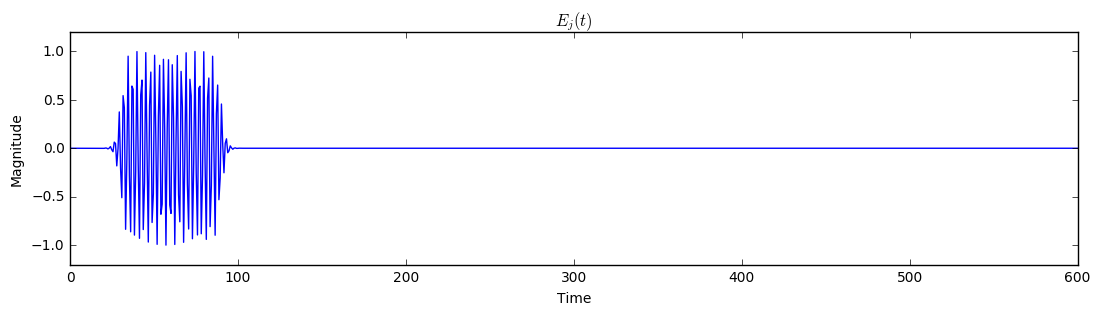

In [6]:
time_c_func = lambdify({'a','b','t','st','w_rf', 'phi'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=args['a'],b=args['b'],st=args['st'],w_rf=args['w_rf'],phi=args['phi'],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators definition

In [7]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, identity(N[1]))
    else:
        return tensor(identity(N[0]), oper)
def THq(qubit,w = w):
    return 0.5*w[qubit-1]*T(sigmaz(),qubit)
def THint(wxx = wxx):
    return 0.5*wxx*tensor(sigmax(), sigmax())
def THf(qubit, f=f):
    return f[qubit-1]*T(sigmax(),qubit)
def THsys_t():
    return [THq(1) + THq(2) + THint(),[THf(1), time_coeff]]
def THsys_t_new():
    return [THq(2) + THint(),[THf(1), time_coeff]]

def TSx(qubit, N = N):
    return T(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T(sigmam(),qubit, N)

# Visualisation

In [88]:
def Tvis_out(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(9,2*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    colors = ["r","g","b","black","black","black","black","black","black"]
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx],linewidth=(2.5 if idy else 1.0),color=colors[idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) )
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            if idy == 1:
                ax.legend(bbox_to_anchor = [1,0],loc = "lower right")
            else:
                ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
            if idx == graphs-1:
                ax.set_xlabel('Time')
            
def Tvis_out_print(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes = plt.subplots(1,2, figsize=(13,5), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx in range(graphs):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
                        

# Dynamics

In [9]:
expected = []
Tpsi0 = tensor(basis(2,1), basis(2,1))

def collapse_list():
    return []
def solve(expected_ops , Tpsi_0 =Tpsi0, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [10]:
def get_pulse_operator():
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    result = []
    for psi_id, Tpsi0 in enumerate(Tpsi):
        out = solve([],Tpsi0)
        state_final = out.states[-1]
        res_state = []
        print(state_final)
        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    print(result)
    return Qobj(result)

In [17]:
op = get_pulse_operator()

10.0%. Run time:   0.19s. Est. time left: 00:00:00:01
20.0%. Run time:   0.42s. Est. time left: 00:00:00:01
30.0%. Run time:   0.65s. Est. time left: 00:00:00:01
40.0%. Run time:   0.88s. Est. time left: 00:00:00:01
50.0%. Run time:   1.14s. Est. time left: 00:00:00:01
60.0%. Run time:   1.36s. Est. time left: 00:00:00:00
70.0%. Run time:   1.54s. Est. time left: 00:00:00:00
80.0%. Run time:   1.68s. Est. time left: 00:00:00:00
90.0%. Run time:   1.82s. Est. time left: 00:00:00:00
Total run time:   1.97s
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.07840875-0.00564868j]
 [ 0.04309405-0.01045385j]
 [-0.42328783-0.55953882j]
 [ 0.43649665-0.555939j  ]]
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.41s. Est. time left: 00:00:00:01
30.0%. Run time:   0.64s. Est. time left: 00:00:00:01
40.0%. Run time:   0.86s. Est. time left: 00:00:00:01
50.0%. Run time:   1.09s. Est. time left: 00:00:00:01
60.0%. Run time:   1.32s. Est. 

In [18]:
op

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.43649665-0.555939j   -0.42328783-0.55953882j  0.04309405-0.01045385j
  -0.07840875-0.00564868j]
 [-0.55169631-0.43254307j  0.55734173-0.4352465j  -0.07729699+0.00975588j
   0.04895668+0.00126434j]
 [-0.04895668+0.00126434j  0.07729699+0.00975588j  0.55734173+0.4352465j
  -0.55169631+0.43254307j]
 [ 0.07840875-0.00564868j -0.04309405-0.01045385j -0.42328783+0.55953882j
   0.43649665+0.555939j  ]]

In [13]:
t_gate = 355.01630
args['b'] = args['a'] + t_gate
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
out = solve([])

10.0%. Run time:   0.22s. Est. time left: 00:00:00:01
20.0%. Run time:   0.47s. Est. time left: 00:00:00:01
30.0%. Run time:   0.72s. Est. time left: 00:00:00:01
40.0%. Run time:   0.99s. Est. time left: 00:00:00:01
50.0%. Run time:   1.23s. Est. time left: 00:00:00:01
60.0%. Run time:   1.45s. Est. time left: 00:00:00:00
70.0%. Run time:   1.63s. Est. time left: 00:00:00:00
80.0%. Run time:   1.77s. Est. time left: 00:00:00:00
90.0%. Run time:   1.95s. Est. time left: 00:00:00:00
Total run time:   2.11s


In [14]:
def observe(output, operators, rotationFreq , every = 1):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
#         time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

def observe_last(output, operators, rotationFreq):
    expectation = []
    time = tlist[-1]
    state = output.states[-1]
    for i, op in enumerate(operators):
        for qubit in [1,2]:
            if rotationFreq[qubit-1] != 0:
                U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                TU = T(U,qubit)
                expectation[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
            else:
                expectation[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return expectation

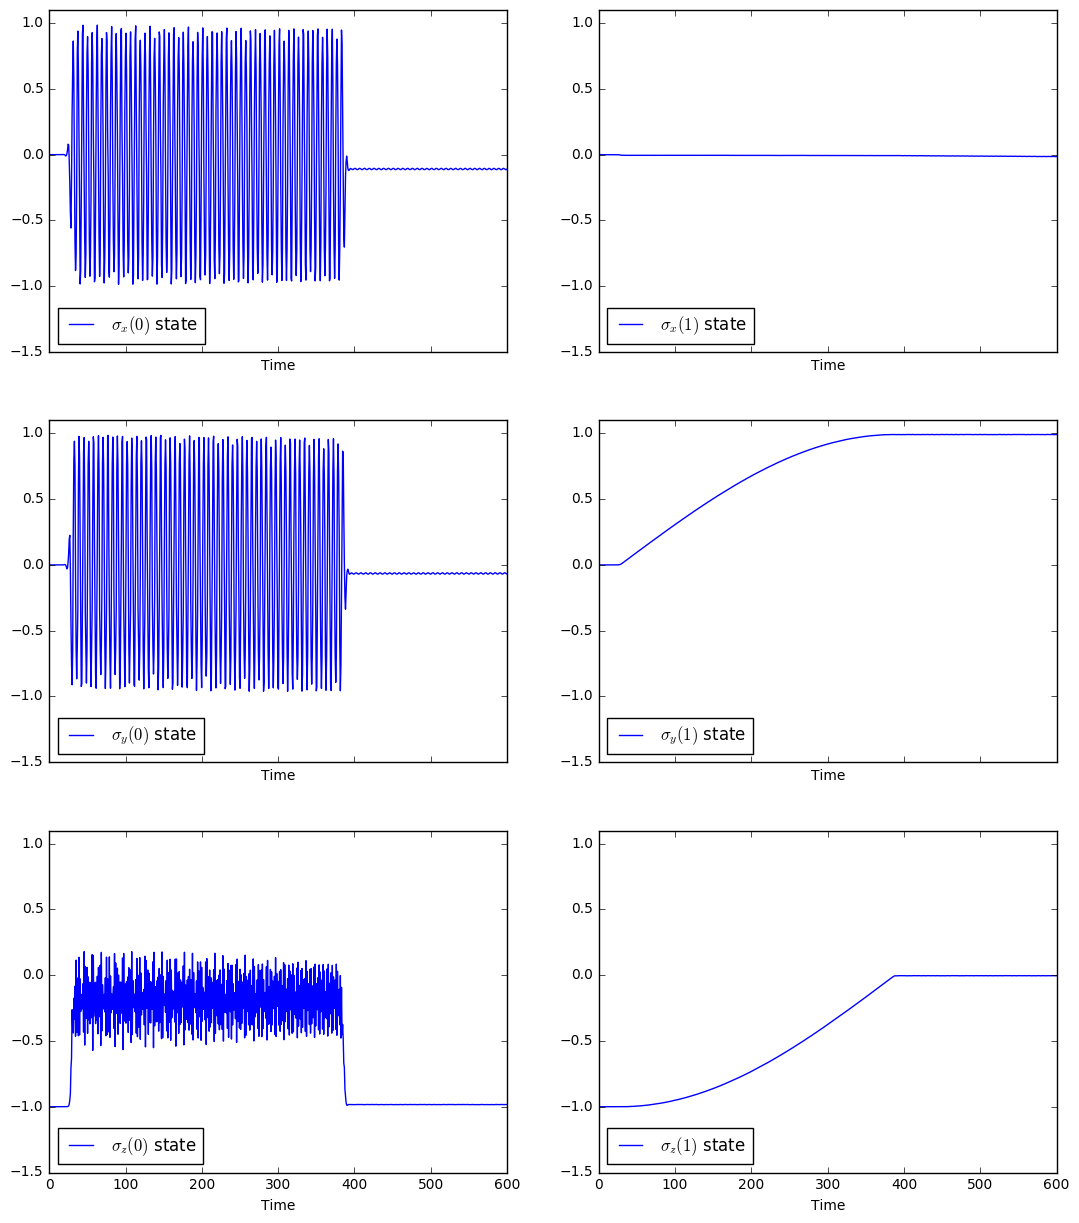

In [16]:
output2 = observe(out, [TSx, TSy, TSz], [w[0],w[1]],1)
Tvis_out(output2,1)

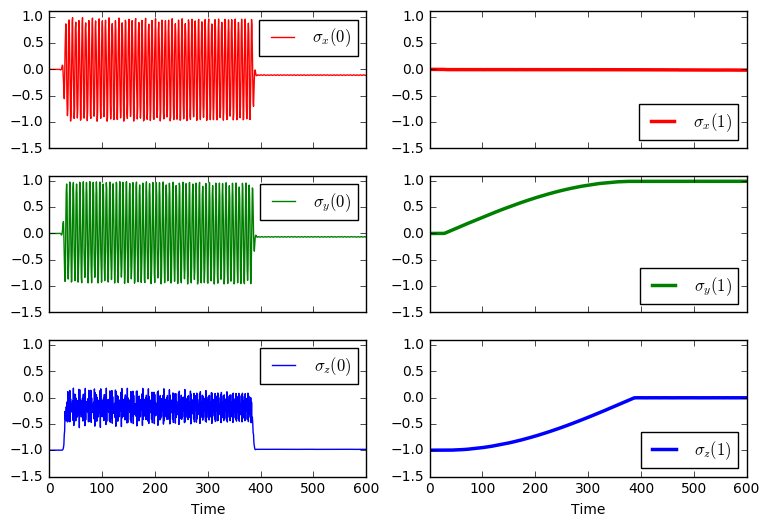

In [89]:
Tvis_out(output2,1)
plt.savefig("CR pulse.pdf",bbox_inches="tight")

In [368]:
expected = [TSz(2)]
def solve_b(expected, b, b_id):
    args['b'] = b
    print(b_id)
    return solve(expected, False)

sz_final = [ (solve_b(expected, args['a'] + db, b_id).expect[0][-1],db) for b_id, db in enumerate(np.linspace(356.016285, 356.01630,5)) ]

0
1
2
3
4


In [369]:
print(sz_final)

[(1.9705215283322489e-07, 356.01628499999998), (1.9705215283322489e-07, 356.01628875), (1.9705215283322489e-07, 356.01629249999996), (1.9705215283322489e-07, 356.01629624999998), (1.9705215283322489e-07, 356.0163)]


In [19]:
ZX = (-0.5*1j*1/2*np.pi*tensor(sigmaz(),sigmax())).expm()

In [20]:
ZI = (0.5*1j*(1/2)*np.pi*tensor(sigmaz(),identity(2))).expm()
ZI

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.70710678j  0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.70710678+0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678-0.70710678j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.70710678-0.70710678j]]

In [21]:
IX = (0.5*1j*(1/2)*np.pi*tensor(identity(2),sigmax())).expm()
IX

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000+0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.70710678j  0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678+0.j
   0.00000000+0.70710678j]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.70710678j
   0.70710678+0.j        ]]

In [22]:
#IZ = (0.5*1j*np.pi*tensor(identity(2),sigmaz())).expm()
ZX

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000-0.70710678j  0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678+0.j
   0.00000000+0.70710678j]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.70710678j
   0.70710678+0.j        ]]

In [23]:
op/op.data.toarray()[0][0]*0.5**0.5

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[  7.07106781e-01+0.j           1.78767197e-01-0.67874528j
    3.48489736e-02+0.02745019j  -4.39960113e-02-0.06518566j]
 [ -4.89745623e-04-0.70132591j   6.86797603e-01+0.16965038j
   -5.54302447e-02-0.05479398j   2.92504410e-02+0.03930266j]
 [ -3.12401249e-02-0.03774046j   4.00774256e-02+0.06684828j
    1.85027822e-03+0.70743818j  -6.81182685e-01-0.16687845j]
 [  5.28853454e-02+0.05820618j  -1.83977551e-02-0.0403669j
   -7.01778930e-01+0.01261732j  -1.67774310e-01+0.68691468j]]

In [26]:
op.dims = [[2,2],[2,2]]

In [27]:
CNOT = ZI*op*ZI*IX
CNOT = CNOT/CNOT.data.toarray()[0][0]

In [35]:
(CNOT+CNOT.conj())/2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.          0.12947982 -0.02090246 -0.01499066]
 [-0.12209009  1.00073266 -0.0094566  -0.01914161]
 [ 0.01063929  0.01814881 -0.12216202  1.00070732]
 [ 0.01971692  0.01589874  0.99985518  0.12939703]]

2level + field.ipynb         rhs23390.pyx     rhs57290.pyx
2level + oscillator.ipynb    rhs2343991.pyx   rhs59170.pyx
2qubit (2d).ipynb            rhs26462187.pyx  rhs59171.pyx
2qubit.ipynb                 rhs2646232.pyx   rhs62180.pyx
charge.ipynb                 rhs294723.pyx    Transmon dynamics 2.ipynb
example.ipynb~               rhs294726.pyx    Transmon dynamics 3.ipynb
pulses 2d (2).ipynb          rhs375720.pyx    Transmon dynamics_old.ipynb
pulses 2d.ipynb              rhs375765.pyx    Untitled1.ipynb
pulses N-d (transmon).ipynb  rhs521646.pyx    Untitled.ipynb
result_occupations_old.txt   rhs521651.pyx
result_occupations.txt       rhs55497.pyx


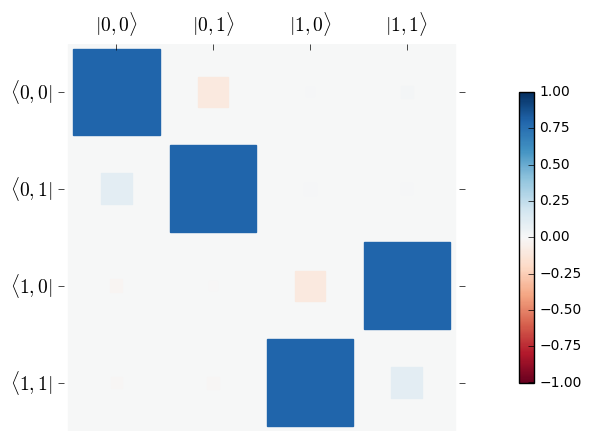

In [90]:
ax1 = plt.subplot(111)
hinton(real(CNOT),ax = ax1)
#ax2 = plt.subplot(122)
#hinton(Qobj(np.angle(CNOT.data.toarray())),ax = ax2)
plt.gcf().set_size_inches(7,5)
plt.savefig("CR CNOT diagram.pdf",bbox_inches = "tight")

In [60]:
CNOT

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j          0.12947982+0.00376285j -0.02090246-0.06948646j
  -0.01499066+0.0534877j ]
 [-0.12209009+0.00526564j  1.00073266-0.00702639j -0.00945660+0.06957701j
  -0.01914161-0.05817542j]
 [ 0.01063929+0.069406j    0.01814881-0.05849275j -0.12216202-0.00318716j
   1.00070732-0.01000501j]
 [ 0.01971692-0.06983212j  0.01589874+0.05322485j  0.99985518-0.01701792j
   0.12939703-0.00596579j]]

In [88]:
expect(TSz(2),ZX * Tpsi0)

-2.220446049250313e-16

In [180]:
new_t_list = np.linspace(0,2,100)
evolution = [(T(sigmaz(),1)*1j*2*np.pi/2 * t).expm()*Tpsi0 for t in new_t_list]

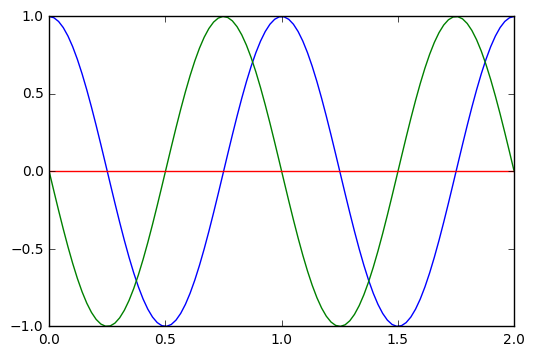

In [181]:
plt.plot(new_t_list, expect(TSx(1),evolution))
plt.plot(new_t_list, expect(TSy(1),evolution))
plt.plot(new_t_list, expect(TSz(1),evolution))


In [50]:
op

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.32873332-0.62666578j -0.51861731-0.47127485j  0.01953673-0.00820476j
  -0.08779763+0.00175506j]
 [-0.62146496-0.32284133j  0.46966567-0.52989318j -0.08449038+0.01830485j
   0.02654408-0.00196778j]
 [-0.02654408-0.00196778j  0.08449038+0.01830485j  0.46966567+0.52989318j
  -0.62146496+0.32284133j]
 [ 0.08779763+0.00175506j -0.01953673-0.00820476j -0.51861731+0.47127485j
   0.32873332+0.62666578j]]